# Step-by-step demonstration

## Lib Imports and configurations

In [1]:
# %matplotlib notebook
# %matplotlib inline 
%load_ext autoreload
%autoreload 2

import sys
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from ruptures.metrics import precision_recall, meantime
import scipy.stats as ss

sys.path.append("Codes/")

import TMPD_utils
import TMPD_class

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)
# pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.options.display.float_format = '{:.4f}'.format


c:\Users\anton\OneDrive\_Cloud Disk\Projetos de programação\Git\Transition_Matrix_Process_Drift\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading event log

In [2]:
# Mapping all event_logs paths
logs_path = glob.glob("Input/Synthetic/Synthetic Event Streams - Resource and Data Perspectives (Antonio)/*.csv")

# Showing mapped paths
print("How many logs? ", len(logs_path))
pd.DataFrame(logs_path).head(30)

How many logs?  3


,0
0,Input/Synthetic/Synthetic Event Streams - Resource and Data Perspectives (Antonio)\recurring_resources_noise0_1000_poc.csv
1,Input/Synthetic/Synthetic Event Streams - Resource and Data Perspectives (Antonio)\recurring_resources_noise0_500_poc.csv
2,Input/Synthetic/Synthetic Event Streams - Resource and Data Perspectives (Antonio)\recurring_time_noise0_1000_baseline.csv


<!-- ![Alt text](../Images/Concept_drift_firstcycle_steps_eng.png "General steps") -->

In [3]:
# Loading first event log
log_path = logs_path[0]
print(log_path.split("\\")[-1].split(".")[0])
event_log = pd.read_csv(log_path, delimiter=";")

# Save original event index
event_log = event_log.reset_index(names='original_index') 


# Showing loaded event log
print("Total events: ", len(event_log))
print("Total cases: ", len(event_log.groupby('case')))
print("Total activities: ", len(event_log.groupby('event')))
event_log.head(15)


recurring_resources_noise0_1000_poc
Total events:  11198
Total cases:  1000
Total activities:  15


,original_index,Event order,case,event,startTime,completeTime,Concept drift,Activity name,Role,Department,Cost,Amount
0,0,0,0,A,2019/01/10 08:00:00,2019/01/10 08:00:00,No,Check application form completeness,Loan Officer,Customer Service,9.9486,9978.7860
1,1,1,1,A,2019/01/10 08:20:00,2019/01/10 08:20:00,No,Check application form completeness,Loan Officer,Customer Service,12.1184,13109.3817
2,2,2,0,B,2019/01/10 08:31:33,2019/01/10 08:31:33,No,Return application back to applicant,Loan Officer,Customer Service,6.9731,9978.7860
3,3,3,2,A,2019/01/10 08:40:00,2019/01/10 08:40:00,No,Check application form completeness,Loan Officer,Customer Service,8.3144,12012.5338
4,4,4,1,D,2019/01/10 08:56:26,2019/01/10 08:56:26,No,Check credit history,Credit Analyst,Customer Service,15.6680,13109.3817
5,5,5,0,C,2019/01/10 08:58:05,2019/01/10 08:58:05,No,Receive updated application,Loan Officer,Customer Service,8.3324,9978.7860
6,6,6,3,A,2019/01/10 09:00:00,2019/01/10 09:00:00,No,Check application form completeness,Loan Officer,Customer Service,9.4452,10560.4655
7,7,7,2,B,2019/01/10 09:05:17,2019/01/10 09:05:17,No,Return application back to applicant,Loan Officer,Customer Service,7.9284,12012.5338
8,8,8,4,A,2019/01/10 09:20:00,2019/01/10 09:20:00,No,Check application form completeness,Loan Officer,Customer Service,12.1763,10783.1078
9,9,9,1,F,2019/01/10 09:28:32,2019/01/10 09:28:32,No,Appraise property,Appraiser,Customer Service,22.3444,13109.3817


## Step 1 - Instantiating class and setting event log

In [4]:
# Iniatializing the TMPD_class
TMPD_instance = TMPD_class.TMPD(scenario='offline')

# Setting the transition log
TMPD_instance.set_transition_log(event_log, case_id='case', activity_key='Activity name', timestamp_key='startTime', timestamp_format="infer", other_columns_keys=["Role", "Department", "Cost", "Amount"])

# Executing the transition log
TMPD_instance.run_transition_log()

# Showing the transition log created
print(len(TMPD_instance.get_transition_log()))
TMPD_instance.get_transition_log().head(15)

12198


,case_id,activity_from,timestamp_from,Role_from,Department_from,Cost_from,Amount_from,event_order_from,activity_to,timestamp_to,Role_to,Department_to,Cost_to,Amount_to,event_order_to,case_order,transition_id
0,0,START,2019-01-10 08:00:00,Loan Officer,Customer Service,9.9486,9978.7860,0,Check_application_form_completeness,2019-01-10 08:00:00,Loan Officer,Customer Service,9.9486,9978.7860,0.0000,0,0
1,0,Check_application_form_completeness,2019-01-10 08:00:00,Loan Officer,Customer Service,9.9486,9978.7860,0,Return_application_back_to_applicant,2019-01-10 08:31:33,Loan Officer,Customer Service,6.9731,9978.7860,2.0000,1,1
2,1,START,2019-01-10 08:20:00,Loan Officer,Customer Service,12.1184,13109.3817,1,Check_application_form_completeness,2019-01-10 08:20:00,Loan Officer,Customer Service,12.1184,13109.3817,1.0000,0,2
3,1,Check_application_form_completeness,2019-01-10 08:20:00,Loan Officer,Customer Service,12.1184,13109.3817,1,Check_credit_history,2019-01-10 08:56:26,Credit Analyst,Customer Service,15.6680,13109.3817,4.0000,1,3
4,0,Return_application_back_to_applicant,2019-01-10 08:31:33,Loan Officer,Customer Service,6.9731,9978.7860,2,Receive_updated_application,2019-01-10 08:58:05,Loan Officer,Customer Service,8.3324,9978.7860,5.0000,2,4
5,2,START,2019-01-10 08:40:00,Loan Officer,Customer Service,8.3144,12012.5338,3,Check_application_form_completeness,2019-01-10 08:40:00,Loan Officer,Customer Service,8.3144,12012.5338,3.0000,0,5
6,2,Check_application_form_completeness,2019-01-10 08:40:00,Loan Officer,Customer Service,8.3144,12012.5338,3,Return_application_back_to_applicant,2019-01-10 09:05:17,Loan Officer,Customer Service,7.9284,12012.5338,7.0000,1,6
7,1,Check_credit_history,2019-01-10 08:56:26,Credit Analyst,Customer Service,15.6680,13109.3817,4,Appraise_property,2019-01-10 09:28:32,Appraiser,Customer Service,22.3444,13109.3817,9.0000,2,7
8,0,Receive_updated_application,2019-01-10 08:58:05,Loan Officer,Customer Service,8.3324,9978.7860,5,Check_application_form_completeness,2019-01-10 09:33:17,Loan Officer,Customer Service,9.4068,9978.7860,10.0000,3,8
9,3,START,2019-01-10 09:00:00,Loan Officer,Customer Service,9.4452,10560.4655,6,Check_application_form_completeness,2019-01-10 09:00:00,Loan Officer,Customer Service,9.4452,10560.4655,6.0000,0,9


## Step 2 - Setting Window Strategy

In [5]:
# Setting the window strategy parameters
TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 500, window_ref_mode = 'Fixed', overlap = True, sliding_step = 50, continuous = True)

# Executing the window strategy indexation
TMPD_instance.run_windowing_strategy()

# Showing the windows indexes
dict(list(TMPD_instance.get_windowing_strategy().items())[:15])

{0: {'start': 0, 'end': 500},
 1: {'start': 50, 'end': 550},
 2: {'start': 100, 'end': 600},
 3: {'start': 150, 'end': 650},
 4: {'start': 200, 'end': 700},
 5: {'start': 250, 'end': 750},
 6: {'start': 300, 'end': 800},
 7: {'start': 350, 'end': 850},
 8: {'start': 400, 'end': 900},
 9: {'start': 450, 'end': 950},
 10: {'start': 500, 'end': 1000},
 11: {'start': 550, 'end': 1050},
 12: {'start': 600, 'end': 1100},
 13: {'start': 650, 'end': 1150},
 14: {'start': 700, 'end': 1200}}

## Step 3 - Setting Process Representation (using Transition Matrix)

In [6]:
# Setting the Transition Matrix (TM) process representation
TMPD_instance.set_process_representation(threshold_anomaly=0
                                    , control_flow_features={'frequency', 'probability'} #, 'causality', 'parallel'
                                    , time_features={('time_avg','timestamp'), ('time_std','timestamp')}
                                    , resource_features={('categorical_encoding_frequency', 'Role'), ('categorical_encoding_probability', 'Role')
                                                        #  , ('categorical_unique', 'Role'), ('categorical_entropy', 'Role')
                                                         } 
                                    , data_features={('numerical_avg', 'Amount'), ('numerical_std', 'Amount')
                                                        , ('numerical_avg', 'Cost'), ('numerical_std', 'Cost')
                                                        , ('categorical_unique', 'Department'), ('categorical_entropy', 'Department')
                                                        , ('categorical_encoding_frequency', 'Department')#, ('categorical_encoding_probability', 'Department')
                                                    }
                                    ) 

# Executing the process_representation using all dataset just for an example
TMPD_instance.run_process_representation(TMPD_instance.transition_log)

# Showing the process representation created
TMPD_instance.get_process_representation().head(15)

frequency  \
activity_from                              activity_to                                             
Appraise_property                          Assess_loan_risk                                 1000   
Approve_application                        END                                               263   
Assess_eligibility                         Prepare_acceptance_pack                           509   
                                           Reject_application                                491   
Assess_loan_risk                           Assess_eligibility                               1000   
Cancel_application                         END                                               246   
Check_application_form_completeness        Check_credit_history                             1000   
                                           Return_application_back_to_applicant             1054   
Check_credit_history                       Appraise_property                                1000   
Check_if_home_insurance_quote_is_requested Send_acceptance_pack                              256   
                                           Send_home_insurance_quote                         253   
Prepare_acceptance_pack                    Check_if_home_insurance_quote_is_requested        509   
Receive_updated_application                Check_application_form_completeness              1054   
Reject_application                         END                                               491   
Return_application_back_to_applicant       Receive_updated_application                      1054   

                                                                                       percentual  \
activity_from                              activity_to                                              
Appraise_property                          Assess_loan_risk                                0.0820   
Approve_application                        END                                             0.0216   
Assess_eligibility                         Prepare_acceptance_pack                         0.0417   
                                           Reject_application                              0.0403   
Assess_loan_risk                           Assess_eligibility                              0.0820   
Cancel_application                         END                                             0.0202   
Check_application_form_completeness        Check_credit_history                            0.0820   
                                           Return_application_back_to_applicant            0.0864   
Check_credit_history                       Appraise_property                               0.0820   
Check_if_home_insurance_quote_is_requested Send_acceptance_pack                            0.0210   
                                           Send_home_insurance_quote                       0.0207   
Prepare_acceptance_pack                    Check_if_home_insurance_quote_is_requested      0.0417   
Receive_updated_application                Check_application_form_completeness             0.0864   
Reject_application                         END                                             0.0403   
Return_application_back_to_applicant       Receive_updated_application                     0.0864   

                                                                                       probability  \
activity_from                              activity_to                                               
Appraise_property                          Assess_loan_risk                                 1.0000   
Approve_application                        END                                              1.0000   
Assess_eligibility                         Prepare_acceptance_pack                          0.5090   
                                           Reject_application                               0.4910   
Assess_loan_risk                           Assess_eligib

## Step 4 - Setting Change Representation

In [7]:
# Defining the change features
change_features_strategy_dict = {
    'delta_matrix_strategy': 
        {
            ### Control Flow Perspective
            'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'probability_delta' : {'process_feature':'probability', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'causality_delta' : {'process_feature':'causality', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'parallel_delta' : {'process_feature':'parallel', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
            # , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}

            ### Time Perspective
            , 'time_avg_delta' : {'process_feature':'time_avg_timestamp', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'time_std_delta' : {'process_feature':'time_std_timestamp', 'method':'aggregation', 'agg_function' : 'sum'}

            ### Resource Perspective
            # , 'role_unique_delta' : {'process_feature':'categorical_unique_Role', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'role_entropy_delta' : {'process_feature':'categorical_entropy_Role', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'role_encoding_frequency_delta' : {'process_feature':'categorical_encoding_frequency_Role', 'method':'multiple_aggregation', 'agg_function' : 'sum'}
            , 'role_encoding_probability_delta' : {'process_feature':'categorical_encoding_probability_Role', 'method':'multiple_aggregation', 'agg_function' : 'sum'}

            ### Data Perspective
            , 'amount_avg_delta' : {'process_feature':'numerical_avg_Amount', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'amount_std_delta' : {'process_feature':'numerical_std_Amount', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'cost_avg_delta' : {'process_feature':'numerical_avg_Cost', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'cost_std_delta' : {'process_feature':'numerical_std_Cost', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'department_unique_delta' : {'process_feature':'categorical_unique_Department', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'department_entropy_delta' : {'process_feature':'categorical_entropy_Department', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'department_encoding_frequency_delta' : {'process_feature':'categorical_encoding_frequency_Department', 'method':'multiple_aggregation', 'agg_function' : 'sum'}
            # , 'department_encoding_probability_delta' : {'process_feature':'categorical_encoding_probability_Department', 'method':'multiple_aggregation', 'agg_function' : 'sum'}
        }
    , 'statistic_test_strategy' : 
        {
            ### Control Flow Perspective
            # 'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            # , 'frequency_cramersv' : {'process_feature':'frequency', 'method':'cramers_v', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}

            ### Time Perspective
            # ,'time_avg_timestamp_gtest_pvalue' : {'process_feature':'time_avg_timestamp', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}

            ### Resource Perspective
            # , 'role_encoding_frequency_gtest_pvalue' : {'process_feature':'categorical_encoding_frequency_Role', 'method':'multiple_g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            # , 'role_encoding_probability_gtest_pvalue' : {'process_feature':'categorical_encoding_probability_Role', 'method':'multiple_g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}

            ### Data Perspective
            # , 'amount_avg_gtest_pvalue' : {'process_feature':'numerical_avg_Amount', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            # , 'amount_std_gtest_pvalue' : {'process_feature':'numerical_std_Amount', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            # , 'cost_avg_gtest_pvalue' : {'process_feature':'numerical_avg_Cost', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            # , 'cost_std_gtest_pvalue' : {'process_feature':'numerical_std_Cost', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            # , 'department_encoding_frequency_gtest_pvalue' : {'process_feature':'categorical_encoding_frequency_Department', 'method':'multiple_g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            # , 'department_encoding_probability_gtest_pvalue' : {'process_feature':'categorical_encoding_probability_Department', 'method':'multiple_g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}

        }
    }

# Setting Change Representation
TMPD_instance.set_change_representation(change_features_strategy_dict)

# Executing the Change Representation using the window strategy
TMPD_instance.run_change_representation()

# Showing the Change Representation created
TMPD_instance.get_change_representation().head(20)

,start,end,reference_window_index,frequency_delta,time_avg_delta,time_std_delta,role_encoding_frequency_delta,role_encoding_probability_delta,amount_avg_delta,cost_avg_delta,department_unique_delta,department_entropy_delta,department_encoding_frequency_delta
0,0,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50,550,0.0000,36.0000,3.4774,1.8706,144.0000,0.0000,3272.5262,4.1578,0.0000,0.0000,144.0000
2,100,600,0.0000,46.0000,6.7664,3.8306,184.0000,0.0000,5827.7891,6.5118,0.0000,0.0000,184.0000
3,150,650,0.0000,40.0000,6.6906,4.6917,160.0000,0.0000,7398.0540,5.5382,0.0000,0.0000,160.0000
4,200,700,0.0000,50.0000,9.0349,3.9293,200.0000,0.0000,11004.0444,5.6810,0.0000,0.0000,200.0000
5,250,750,0.0000,58.0000,8.9912,5.4244,232.0000,0.0000,15921.8748,6.3947,0.0000,0.0000,232.0000
6,300,800,0.0000,66.0000,9.5154,7.3154,264.0000,0.0000,21379.5175,9.2154,0.0000,0.0000,264.0000
7,350,850,0.0000,86.0000,9.2334,8.0267,344.0000,0.0000,27511.3358,10.7479,0.0000,0.0000,344.0000
8,400,900,0.0000,86.0000,9.9518,9.2690,344.0000,0.0000,27854.9858,9.4078,0.0000,0.0000,344.0000
9,450,950,0.0000,80.0000,10.9114,10.5169,320.0000,0.0000,26331.3663,10.7881,0.0000,0.0000,320.0000


## Step 5 - Setting Detection Task

In [8]:
# Defining detection strategies
detection_task_strategy_dict = {
    'time_series_strategy': 
    {
        ### Control Flow Perspective
        'cpd_frequency_delta' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_freq_delta' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_causality_delta' : {'change_features':['causality_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_parallel_delta' : {'change_features':['parallel_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'

        ### Time Perspective
        , 'cpd_time_avg_delta' : {'change_features':['time_avg_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_time_std_delta' : {'change_features':['time_std_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'

        ### Resource Perspective
        # , 'cpd_role_unique_delta' : {'change_features':['role_unique_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_role_entropy_delta' : {'change_features':['role_entropy_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_role_encoding_frequency_delta' : {'change_features':['role_encoding_frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_role_encoding_probability_delta' : {'change_features':['role_encoding_probability_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'

        ### Data Perspective
        , 'cpd_amount_avg_delta' : {'change_features':['amount_avg_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_amount_std_delta' : {'change_features':['amount_std_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_cost_avg_delta' : {'change_features':['cost_avg_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_cost_std_delta' : {'change_features':['cost_std_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_department_unique_delta' : {'change_features':['department_unique_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1
        , 'cpd_department_entropy_delta' : {'change_features':['department_entropy_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1
        , 'cpd_department_encoding_frequency_delta' : {'change_features':['department_encoding_frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1
        # , 'cpd_department_encoding_probability_delta' : {'change_features':['department_encoding_probability_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1
    }
    , 'threshold_strategy' : 
    {
        ### Control Flow Perspective
        # 'gtest_frequency' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' : '3'}
        # , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
        # , 'fixed_frequency_delta_percentage' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}

        ### Time Perspective
        # ,'gtest_time_avg_timestamp' : {'change_features':['time_avg_timestamp_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' :'3'}

        ### Resource Perspective
        # , 'gtest_role_encoding_frequency' : {'change_features':['role_encoding_frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' :'3'}
        # , 'gtest_role_encoding_probability' : {'change_features':['role_encoding_probability_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' :'3'}

        ### Data Perspective
        # , 'gtest_amount_avg' : {'change_features':['amount_avg_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' :'3'}
        # , 'gtest_amount_std' : {'change_features':['amount_std_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' :'3'}
        # , 'gtest_cost_avg' : {'change_features':['cost_avg_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' :'3'}
        # , 'gtest_cost_std' : {'change_features':['cost_std_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' :'3'}
        # , 'gtest_department_encoding_frequency' : {'change_features':['department_encoding_frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' :'3'}
        # , 'gtest_department_encoding_probability' : {'change_features':['department_encoding_probability_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' :'3'}
        
    }
}

# Setting Detection Task
TMPD_instance.set_detection_task(detection_task_strategy_dict)

# Executing the Detection Task
TMPD_instance.run_detection_task()

# Showing Detection Task Results
TMPD_instance.get_detection_task()


,detection_strategy,detection_feature,detection_results
0,time_series_strategy,cpd_frequency_delta,"[44, 75, 92, 125, 137, 197, 216, 234]"
1,time_series_strategy,cpd_time_avg_delta,"[71, 82, 162, 234]"
2,time_series_strategy,cpd_time_std_delta,"[73, 84, 156, 167, 234]"
3,time_series_strategy,cpd_role_encoding_frequency_delta,"[44, 78, 155, 166, 234]"
4,time_series_strategy,cpd_role_encoding_probability_delta,"[72, 83, 155, 166, 234]"
5,time_series_strategy,cpd_amount_avg_delta,"[71, 82, 152, 163, 234]"
6,time_series_strategy,cpd_cost_avg_delta,"[70, 81, 154, 165, 234]"
7,time_series_strategy,cpd_department_unique_delta,"[70, 84, 153, 166, 234]"
8,time_series_strategy,cpd_department_entropy_delta,"[72, 84, 153, 166, 234]"
9,time_series_strategy,cpd_department_encoding_frequency_delta,"[71, 82, 155, 166, 234]"


In [9]:
# Grounding truth
log_size = event_log['case'].nunique()
ground_truth_traces_indexes = list(range(int(log_size/3), log_size, int(log_size/3+1)))

transition_log = TMPD_instance.get_transition_log()
ground_truth_events_indexes = transition_log[transition_log['case_id'].isin(ground_truth_traces_indexes)].groupby('case_id').first()['transition_id'].to_list()

# signals_indexes = signals.reset_index()
signals = TMPD_instance.get_change_representation()
ground_truth = []
for ground_truth_events_index in ground_truth_events_indexes:
    ground_truth.extend(signals[(signals['start'] <= ground_truth_events_index) 
                & (signals['end'] >= ground_truth_events_index)].head(1).index.to_list())
ground_truth = ground_truth + [len(signals)]
print("ground_truth: ", ground_truth)

ground_truth:  [73, 154, 234]


In [10]:
### Validation metrics
margin_error_defined=3
detection_task_results = TMPD_instance.get_detection_task()
for index, row in detection_task_results.iterrows():
    try:
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)

        # smooth = int(detection_task_strategy_dict[row['detection_strategy']][row['detection_feature']]['smooth'])

        # Margin of error give more margin to overlap if used.
        margin_error = int(margin_error_defined + 1)  if TMPD_instance.overlap == False else int(margin_error_defined + 1 + TMPD_instance.window_size/TMPD_instance.sliding_step)

        precision, recall = precision_recall(ground_truth, row['detection_results'], margin=margin_error)

        f1 = round(ss.hmean([precision, recall]),2)
        detection_task_results.loc[index, 'f1'] = f1
        
        delay = round(meantime(ground_truth, row['detection_results']), 2)
        detection_task_results.loc[index, 'delay'] = delay

    except Exception as e:
        print("Error:", e)
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)
        detection_task_results.loc[index, 'f1'] = np.nan
        detection_task_results.loc[index, 'delay'] = np.nan

detection_task_results

,detection_strategy,detection_feature,detection_results,ground_truth,f1,delay
0,time_series_strategy,cpd_frequency_delta,"[44, 75, 92, 125, 137, 197, 216, 234]","[73, 154, 234]",0.2200,28.7100
1,time_series_strategy,cpd_time_avg_delta,"[71, 82, 162, 234]","[73, 154, 234]",0.8000,6.3300
2,time_series_strategy,cpd_time_std_delta,"[73, 84, 156, 167, 234]","[73, 154, 234]",0.6700,6.5000
3,time_series_strategy,cpd_role_encoding_frequency_delta,"[44, 78, 155, 166, 234]","[73, 154, 234]",0.6700,11.7500
4,time_series_strategy,cpd_role_encoding_probability_delta,"[72, 83, 155, 166, 234]","[73, 154, 234]",0.6700,6.0000
5,time_series_strategy,cpd_amount_avg_delta,"[71, 82, 152, 163, 234]","[73, 154, 234]",0.6700,5.5000
6,time_series_strategy,cpd_cost_avg_delta,"[70, 81, 154, 165, 234]","[73, 154, 234]",0.6700,5.5000
7,time_series_strategy,cpd_department_unique_delta,"[70, 84, 153, 166, 234]","[73, 154, 234]",0.6700,6.7500
8,time_series_strategy,cpd_department_entropy_delta,"[72, 84, 153, 166, 234]","[73, 154, 234]",0.6700,6.2500
9,time_series_strategy,cpd_department_encoding_frequency_delta,"[71, 82, 155, 166, 234]","[73, 154, 234]",0.6700,6.0000


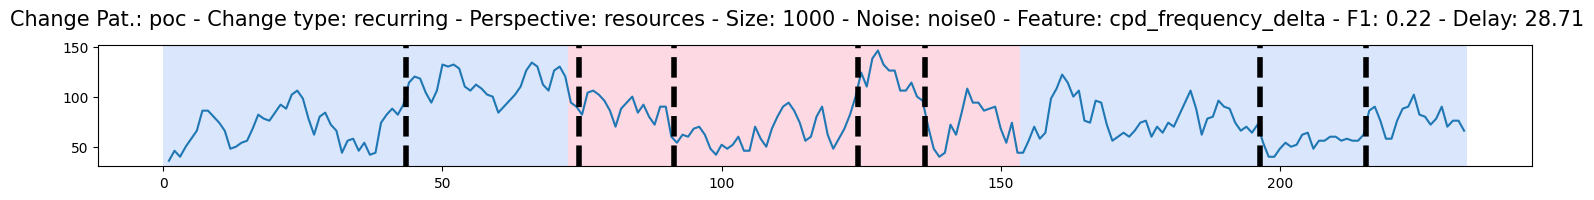

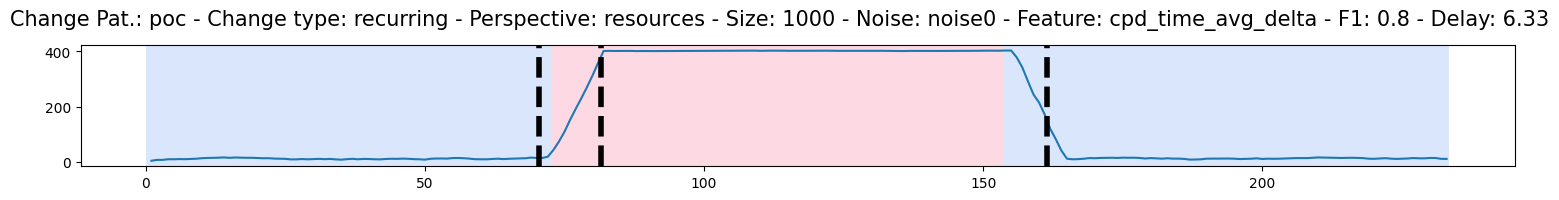

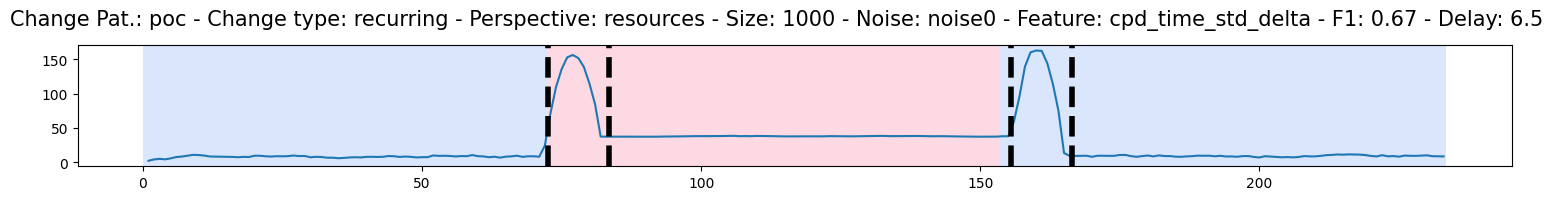

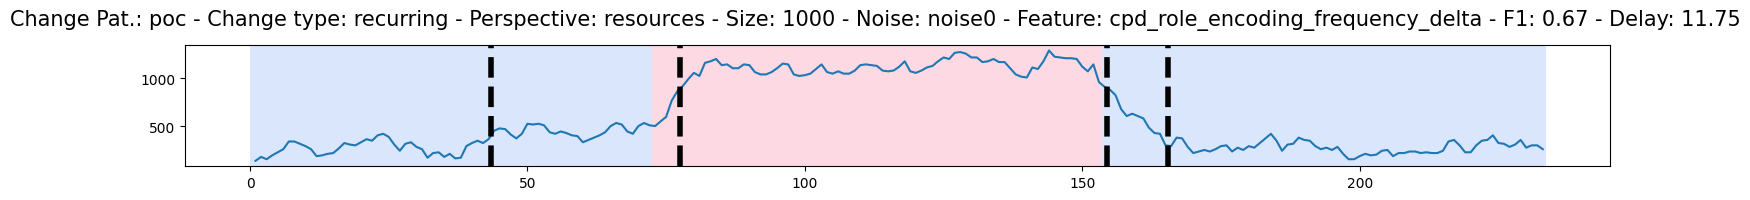

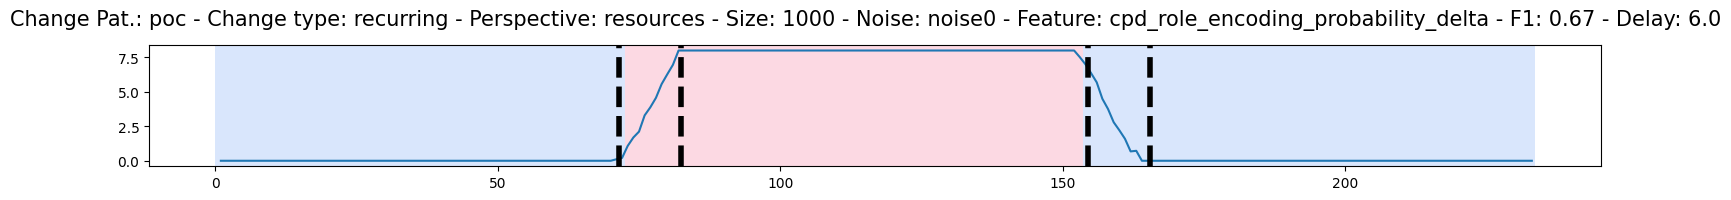

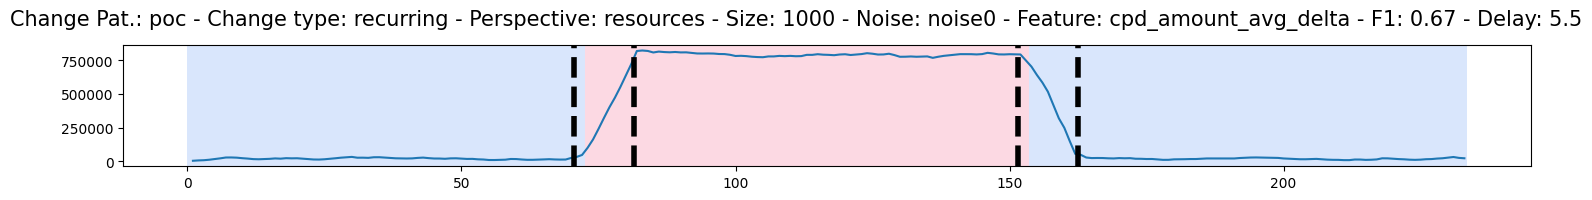

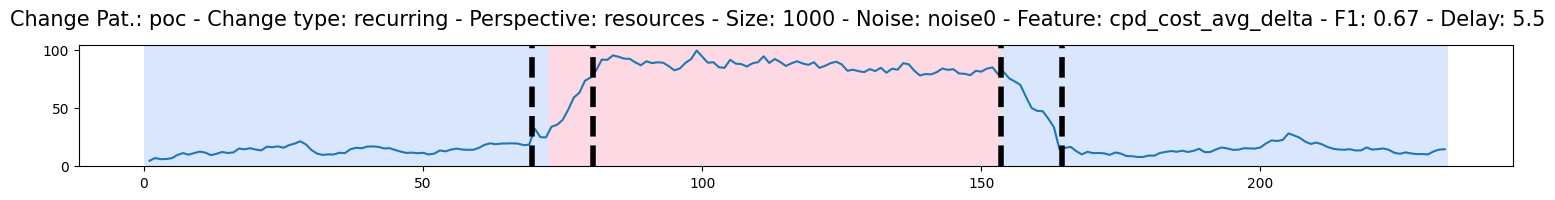

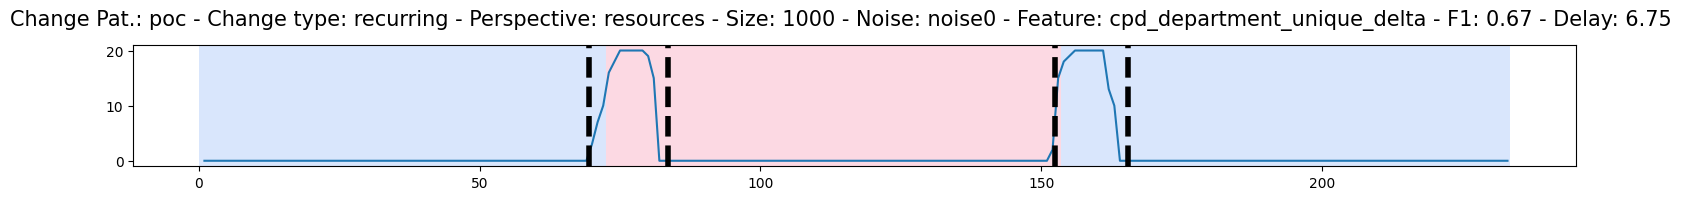

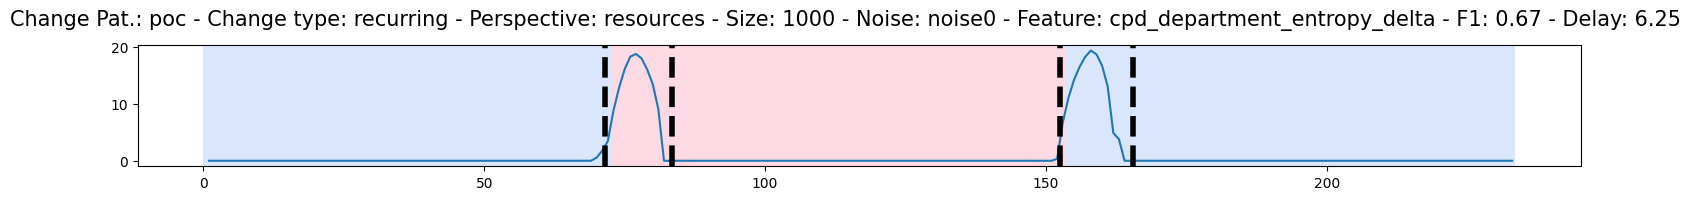

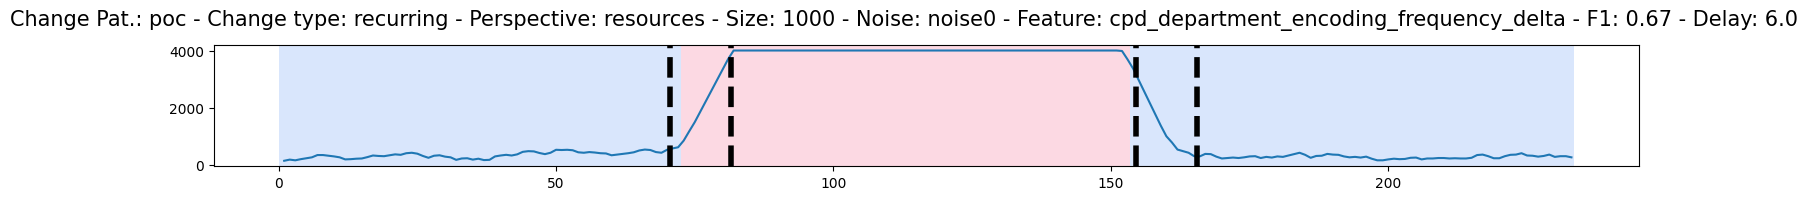

In [11]:
# Display Detection Task Results 
for result in detection_task_results.itertuples():
    fig, axarr = rpt.display(signal = TMPD_instance.get_change_representation()[TMPD_instance.detection_task_strategy_dict[result.detection_strategy][result.detection_feature]['change_features']]
                , true_chg_pts=ground_truth
                , computed_chg_pts = result.detection_results
                , computed_chg_pts_color = "k"
                , computed_chg_pts_linewidth = 4
                , computed_chg_pts_linestyle = "--"
                , computed_chg_pts_alpha = 1
                , figsize=(15, 2)
                )
    plt.suptitle("Change Pat.: " + log_path.split("/")[-1].split("_")[-1].split(".")[0]
                 + " - Change type: " + log_path.split("/")[-1].split("_")[-5].split("\\")[-1]
                 + " - Perspective: " + log_path.split("/")[-1].split("_")[-4]
                 + " - Size: " + log_path.split("/")[-1].split("_")[-2]
                 + " - Noise: " + log_path.split("/")[-1].split("_")[-3] 
                 + " - Feature: " + result.detection_feature
                 + " - F1: " + str(result.f1) 
                 + " - Delay: " + str(result.delay)
                 , fontsize=15)

    plt.subplots_adjust(top=0.8)
    plt.show()

## Step 6a - Setting Localization Task

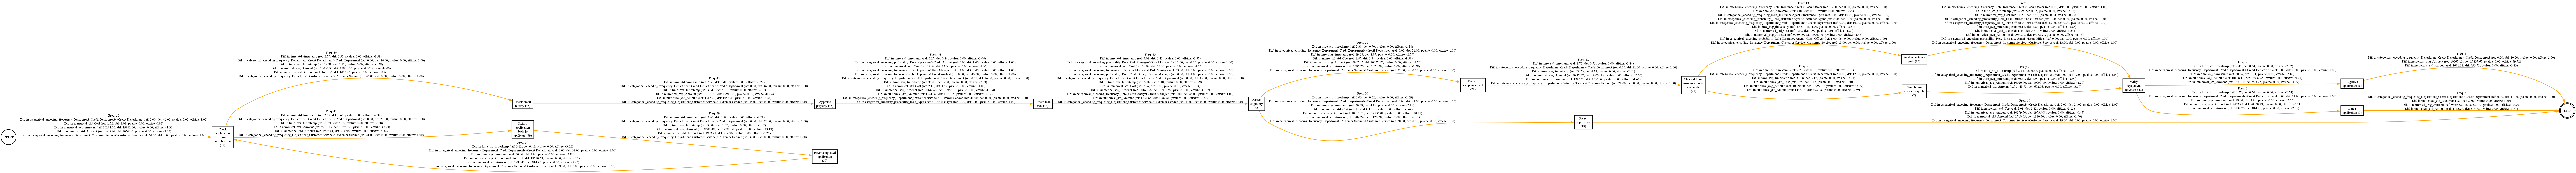

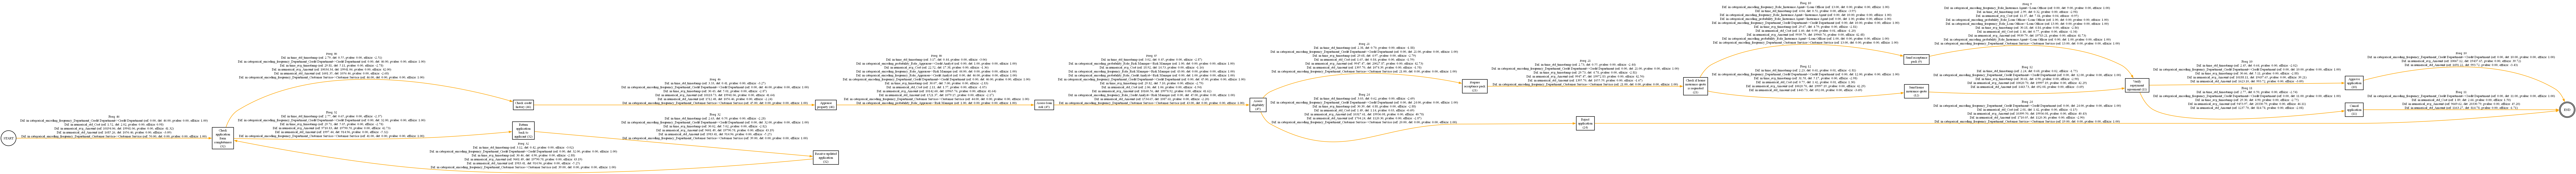

In [12]:
# Setting Localization Task
reference_window_index=0 
detection_window_index=150

TMPD_instance.set_localization_task(reference_window_index=reference_window_index, detection_window_index=detection_window_index, pvalue_threshold=0.05, effect_threshold=0.2, presence_percentage_threshold=0.02, pseudo_count=5)

# Executing Localization Task
TMPD_instance.run_localization_task()

# Showing Localization Task Results
changed_transitions, change_informations, reference_bpmn_text, detection_bpmn_text = TMPD_instance.get_localization_task(show_localization_dfg=True, show_original_dfg=False, show_original_bpmn=False)

In [25]:
changed_transitions.to_csv("changed_transitions.csv")
changed_transitions[changed_transitions["feature"] == "numerical_avg_Cost"]

,transition,feature,perspective,transition_status,activity_status,p_value,effect_size,ref_value,det_value,dif_value
2,"(Appraise_property, Assess_loan_risk)",numerical_avg_Cost,data,significant difference,no change,0.0000,-1.3625,22.5157,17.3830,-5.1327
31,"(Assess_loan_risk, Assess_eligibility)",numerical_avg_Cost,data,significant difference,no change,0.0000,-1.1636,18.9151,14.5315,-4.3835
109,"(Send_acceptance_pack, Verify_repayment_agreement)",numerical_avg_Cost,data,significant difference,no change,0.0387,-0.9469,11.3726,7.8055,-3.5671


In [14]:
change_informations

{'Transitions with variations in categorical_encoding_frequency_Role_Insurance Agent->Loan Officer': [('Check_if_home_insurance_quote_is_requested',
   'Send_acceptance_pack'),
  ('Send_acceptance_pack', 'Verify_repayment_agreement')],
 'Transitions with variations in time_std_timestamp': [('Appraise_property',
   'Assess_loan_risk'),
  ('Assess_eligibility', 'Prepare_acceptance_pack'),
  ('Assess_eligibility', 'Reject_application'),
  ('Assess_loan_risk', 'Assess_eligibility'),
  ('Check_application_form_completeness', 'Check_credit_history'),
  ('Check_application_form_completeness',
   'Return_application_back_to_applicant'),
  ('Check_credit_history', 'Appraise_property'),
  ('Check_if_home_insurance_quote_is_requested', 'Send_acceptance_pack'),
  ('Check_if_home_insurance_quote_is_requested', 'Send_home_insurance_quote'),
  ('Prepare_acceptance_pack', 'Check_if_home_insurance_quote_is_requested'),
  ('Receive_updated_application', 'Check_application_form_completeness'),
  ('Return

In [15]:
reference_bpmn_text, detection_bpmn_text

("Sequence( Loop( 'Check_application_form_completeness', Sequence( 'Return_application_back_to_applicant', 'Receive_updated_application' ) ), 'Check_credit_history', 'Appraise_property', 'Assess_loan_risk', 'Assess_eligibility', Conditional( 'Reject_application', Sequence( 'Prepare_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', Conditional( 'Send_acceptance_pack', 'Send_home_insurance_quote' ), 'Verify_repayment_agreement', Conditional( 'Approve_application', 'Cancel_application' ) ) ) )",
 "Sequence( Loop( 'Check_application_form_completeness', Sequence( 'Return_application_back_to_applicant', 'Receive_updated_application' ) ), 'Check_credit_history', 'Appraise_property', 'Assess_loan_risk', 'Assess_eligibility', Conditional( 'Reject_application', Sequence( 'Prepare_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', Conditional( 'Send_acceptance_pack', 'Send_home_insurance_quote' ), 'Verify_repayment_agreement', Conditional( 'Approve_application', 'Cancel

In [16]:
# Debug

## Getting the reference window
TMPD_instance.run_process_representation(TMPD_instance.transition_log[TMPD_instance.get_windowing_strategy()[reference_window_index]['start']:TMPD_instance.get_windowing_strategy()[reference_window_index]['end']])
reference_window_df = TMPD_instance.get_process_representation()
reference_window_df.to_csv("reference_window_df.csv")
reference_window_df

frequency  \
activity_from                              activity_to                                             
Appraise_property                          Assess_loan_risk                                   44   
Approve_application                        END                                                 8   
Assess_eligibility                         Prepare_acceptance_pack                            21   
                                           Reject_application                                 20   
Assess_loan_risk                           Assess_eligibility                                 43   
Cancel_application                         END                                                 7   
Check_application_form_completeness        Check_credit_history                               46   
                                           Return_application_back_to_applicant               41   
Check_credit_history                       Appraise_property                                  45   
Check_if_home_insurance_quote_is_requested Send_acceptance_pack                               13   
                                           Send_home_insurance_quote                           7   
Prepare_acceptance_pack                    Check_if_home_insurance_quote_is_requested         21   
Receive_updated_application                Check_application_form_completeness                39   
Reject_application                         END                                                19   
Return_application_back_to_applicant       Receive_updated_application                        39   
START                                      Check_application_form_completeness                50   
Send_acceptance_pack                       Verify_repayment_agreement                         13   
Send_home_insurance_quote                  Verify_repayment_agreement                          7   
Verify_repayment_agreement                 Approve_application                                 9   
                                           Cancel_application                                  8   

                                                                                       percentual  \
activity_from                              activity_to                                              
Appraise_property                          Assess_loan_risk                                0.0880   
Approve_application                        END                                             0.0160   
Assess_eligibility                         Prepare_acceptance_pack                         0.0420   
                                           Reject_application                              0.0400   
Assess_loan_risk                           Assess_eligibility                              0.0860   
Cancel_application                         END                                             0.0140   
Check_application_form_completeness        Check_credit_history                            0.0920   
                                           Return_application_back_to_applicant            0.0820   
Check_credit_history                       Appraise_property                               0.0900   
Check_if_home_insurance_quote_is_requested Send_acceptance_pack                            0.0260   
                                           Send_home_insurance_quote                       0.0140   
Prepare_acceptance_pack                    Check_if_home_insurance_quote_is_requested      0.0420   
Receive_updated_application                Check_application_form_completeness             0.0780   
Reject_application                         END                                             0.0380   
Return_application_back_to_applicant       Receive_updated_application                     0.0780   
START                                      Check_application_form_completeness             0.1000   
Send_acceptance_pack                       Verify_repayment_agreemen

In [17]:
## Getting the detection window
TMPD_instance.run_process_representation(TMPD_instance.transition_log[TMPD_instance.get_windowing_strategy()[detection_window_index]['start']:TMPD_instance.get_windowing_strategy()[detection_window_index]['end']])
detection_window_df = TMPD_instance.get_process_representation()
detection_window_df.to_csv("detection_window_df.csv")
detection_window_df

frequency  \
activity_from                              activity_to                                             
Appraise_property                          Assess_loan_risk                                   46   
Approve_application                        END                                                10   
Assess_eligibility                         Prepare_acceptance_pack                            21   
                                           Reject_application                                 24   
Assess_loan_risk                           Assess_eligibility                                 45   
Cancel_application                         END                                                11   
Check_application_form_completeness        Check_credit_history                               46   
                                           Return_application_back_to_applicant               32   
Check_credit_history                       Appraise_property                                  46   
Check_if_home_insurance_quote_is_requested Send_acceptance_pack                               10   
                                           Send_home_insurance_quote                          12   
Prepare_acceptance_pack                    Check_if_home_insurance_quote_is_requested         21   
Receive_updated_application                Check_application_form_completeness                32   
Reject_application                         END                                                24   
Return_application_back_to_applicant       Receive_updated_application                        32   
START                                      Check_application_form_completeness                46   
Send_acceptance_pack                       Verify_repayment_agreement                          9   
Send_home_insurance_quote                  Verify_repayment_agreement                         12   
Verify_repayment_agreement                 Approve_application                                10   
                                           Cancel_application                                 11   

                                                                                       percentual  \
activity_from                              activity_to                                              
Appraise_property                          Assess_loan_risk                                0.0920   
Approve_application                        END                                             0.0200   
Assess_eligibility                         Prepare_acceptance_pack                         0.0420   
                                           Reject_application                              0.0480   
Assess_loan_risk                           Assess_eligibility                              0.0900   
Cancel_application                         END                                             0.0220   
Check_application_form_completeness        Check_credit_history                            0.0920   
                                           Return_application_back_to_applicant            0.0640   
Check_credit_history                       Appraise_property                               0.0920   
Check_if_home_insurance_quote_is_requested Send_acceptance_pack                            0.0200   
                                           Send_home_insurance_quote                       0.0240   
Prepare_acceptance_pack                    Check_if_home_insurance_quote_is_requested      0.0420   
Receive_updated_application                Check_application_form_completeness             0.0640   
Reject_application                         END                                             0.0480   
Return_application_back_to_applicant       Receive_updated_application                     0.0640   
START                                      Check_application_form_completeness             0.0920   
Send_acceptance_pack                       Verify_repayment_agreemen

In [18]:
# Getting the change representation table
TMPD_instance.get_change_representation().iloc[detection_window_index]

start                                   7500.0000
end                                     8000.0000
reference_window_index                     0.0000
frequency_delta                           68.0000
time_avg_delta                           402.6060
time_std_delta                            37.0217
role_encoding_frequency_delta           1120.0000
role_encoding_probability_delta            8.0000
amount_avg_delta                      795247.0699
cost_avg_delta                            81.0293
department_unique_delta                    0.0000
department_entropy_delta                   0.0000
department_encoding_frequency_delta     4000.0000
Name: 150, dtype: float64

## Step 6b - Setting Characterization Task

In [19]:
# Setting Characterization Task
# TMPD_instance.set_characterization_task(llm_company = "openai", llm_model="gpt-4o", api_key_path='Temp/openai_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_general_approach.yaml') # "gpt-4o", "gpt-3.5-turbo-0125", "gpt-4"
TMPD_instance.set_characterization_task(llm_company = "google", llm_model="gemini-2.5-flash", api_key_path='Temp/google_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_general_approach.yaml')

# Executing Characterization Task
TMPD_instance.run_characterization_task()

# Showing Characterization Task Results
characterization_prompt, characterization_response = TMPD_instance.get_characterization_task()

In [20]:
print(characterization_prompt)

### Role and Goal ###
You are an expert process mining analyst specializing in concept drift characterization. Your objective is to deeply understand and explain the transformation observed between two versions of a business process. This includes identifying what changed, how the changes are interconnected, and what broader patterns and impacts they suggest — always grounded in the provided data sources.

**Your analysis must go beyond simply listing differences.** The user has access to the raw data and statistical tables. Your job is to interpret this information holistically, identify key insights, and present a coherent narrative that explains the *nature*, *scope*, and *interconnectedness* of the changes.

### Input Data ###
  - reference_window_df: Transition matrix BEFORE change with columns:
      * activity_from, activity_to: transition identifiers (always available)
      * frequency, percentual: control-flow metrics (always available)
      * Additional columns depend on us

In [21]:
print(characterization_response)

### Executive Summary ###
The business process has undergone a significant and widespread transformation, primarily characterized by a **major organizational restructuring** and a **dramatic increase in processing efficiency and value**. While the fundamental control-flow structure (sequence of activities and decision points) remains unchanged, nearly all transitions exhibit substantial shifts in resource allocation, processing times, and the financial attributes of the cases being handled. The changes are global in scope, affecting the entire process flow, and suggest a strategic pivot towards handling higher-value applications with greater specialization and speed.

### Integrated Change Characterization ###

**Control-Flow Evolution**
Despite the BPMN structure remaining identical between the reference and detection windows, indicating no new or deleted activities or reordering of major process fragments, there are notable shifts in the frequency and probability of certain paths.
* 

## Step 6c - Setting Explanation Task

In [22]:
# TODO